## <ins>CHARGEMENT DES DEPENDANCES</ins>

In [1]:
import tensorflow as tf
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import keras
import numpy as np
import pandas as pd

from glob import glob

from matplotlib.image import imread


from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-05 09:57:06.882609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 09:57:10.183350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/antoine/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <ins>CHARGEMENT DES MODELES TEXTE & IMAGE</ins>


In [2]:
# Chargement du modèle BERT
model_path = "./sauvegarde_modele/modele_BERT_texte/bert-text-classification-model_3epochs"
model_txt = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path, max_length=512)
nlp= pipeline("text-classification", model=model_txt, tokenizer=tokenizer)

In [3]:
# Chargement du modèle EfficientNetB1
model_img = tf.keras.models.load_model("sauvegarde_modele/efficientnetV2/efficientnetV2.keras")
model_img.compile(loss = keras.losses.CategoricalFocalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics=['accuracy'])

2024-06-05 09:57:24.902830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-05 09:57:24.903425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [192]:
df = pd.read_csv("test_df.csv", index_col= 0)
df.head(5)

,prdtypecode,filepath,produit_clean
81417,1320,./images/train/image_1319550229_product_421449...,papier jouet tortue tirer jouet enfants bricol...
650,2060,./images/train/image_1289199379_product_408622...,leopard cristal acrylique géométrique miroir a...
7055,1280,./images/train/image_1098949166_product_169226...,boite musique noël wish you merry christmas bo...
15371,1140,./images/train/image_1176785754_product_296131...,funko pop vinyl nfl jason witten cowboy
72558,2583,./images/train/image_1247849820_product_381357...,kit piscine acier aspect bois gré sicilia oval...


In [5]:
test_texts = list(df.produit_clean.astype(str))

tokenized_sequence = [tokenizer(sequence, max_length=150, truncation=True, padding='max_length') for sequence in test_texts]

test_labels = list(df.prdtypecode)

## <ins>PREDICTION SUR LE TEXTE</ins>

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
probs_text = []  
test_texts_pred = []
for sequence in test_texts:    # Encoder le texte avec le tokenizer
    encoded_input = tokenizer(sequence, return_tensors="pt", max_length=150, truncation=True, padding='max_length')
    # Obtenir les probabilités pour chaque classe
    with torch.no_grad():
        output = model_txt(**encoded_input, return_dict=True)
        probabilities = output.logits.softmax(-1)    
        # Obtenez les étiquettes de classe prédites en trouvant l'index de colonne avec la probabilité maximale
        _, pred = torch.max(probabilities, dim=1)        
    probs_text.append(probabilities.cpu().detach().numpy()[0])
    test_texts_pred.append(pred.item())
        

In [7]:
# Récupération du dictionnaire id2label et label2id
id2label = dict(model_txt.config.id2label)
label2id = dict(model_txt.config.label2id)

# Utilisation des dictionnaires
label_names = list(id2label.values())
label_ids = list(label2id.keys())

In [19]:
test_texts_pred_map = [id2label[x] for x in test_texts_pred]
print(test_texts_pred_map)


['1280', '2060', '1280', '1140', '2583', '40', '1280', '2583', '2522', '2583', '1281', '1920', '1280', '2705', '1300', '2583', '1300', '2220', '2060', '1281', '40', '2522', '2220', '2060', '2583', '1920', '10', '1940', '1302', '1920', '1280', '1320', '2705', '1281', '1300', '1140', '1302', '2585', '2582', '2280', '2705', '2585', '2280', '2585', '1280', '1560', '50', '40', '10', '2522', '2582', '1280', '2280', '40', '1320', '1281', '1320', '1280', '10', '1920', '2583', '2705', '2280', '2583', '1300', '2280', '1320', '1940', '1302', '2462', '1940', '2522', '2522', '2060', '1300', '1560', '40', '1280', '1140', '2582', '2060', '1280', '2583', '2705', '1180', '40', '1560', '2403', '1320', '2705', '2060', '50', '1160', '1920', '2583', '10', '1160', '2522', '1320', '2583', '1300', '2705', '2280', '2705', '2403', '1302', '2280', '1140', '10', '2060', '2583', '2522', '1300', '2583', '2583', '2403', '2060', '2583', '1280', '2403', '1140', '2280', '1920', '2403', '2585', '1560', '2522', '1280', '

In [23]:
y_true = list(df.prdtypecode.astype(str))

print("accuracy modèle Bert :", accuracy_score(y_true,test_texts_pred_map))


accuracy modèle Bert : 0.8481218807459943


#### <ins>Création d'une liste contenant des dictionnaire de type {"label": proba} par ligne du DF</ins>

In [24]:
list_probs_text = []
for x in range(len(probs_text)):
    ditc_test = {}
    for idx, i in enumerate(probs_text[x]):
        ditc_test[id2label[idx]] = i
    list_probs_text.append(ditc_test)


In [25]:
len(list_probs_text)

19035

## <ins>PREDICTION SUR LES IMAGES</ins>

In [26]:
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [27]:
df['prdtypecode'] = df['prdtypecode'].astype(str)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=df,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (380,380),
    batch_size= 1,
    class_mode= 'categorical',
    shuffle = False, 
    )

Found 19035 validated image filenames belonging to 27 classes.


In [28]:
# Probabilités renvoyées par le modèle
y_prob = model_img.predict(test_generator, batch_size=1)

/home/antoine/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19035/19035 ━━━━━━━━━━━━━━━━━━━━ 17163s 901ms/step


In [29]:
y_prob = np.array(y_prob)

In [195]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

y_pred_img = tf.argmax(y_prob, axis=-1).numpy()
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
# Calcul accuracy
print ("ACCURACY DU MODELE : ", accuracy_score(y_test, y_pred_img), end = "\n\n")
# Calcul f1_score
print("F1_SCORE_WEIGHTED : ", f1_score(y_test, y_pred_img, average = 'weighted'), end = "\n\n")
# Rapport de classification
print(classification_report(y_test, y_pred_img, target_names = class_labels), end = "\n\n")     



ACCURACY DU MODELE :  0.6700288941423693

F1_SCORE_WEIGHTED :  0.6608142561843375

              precision    recall  f1-score   support

          10       0.48      0.29      0.36       649
        1140       0.69      0.72      0.71       509
        1160       0.91      0.87      0.89       691
        1180       0.66      0.33      0.44       148
        1280       0.61      0.43      0.50      1105
        1281       0.49      0.35      0.41       499
        1300       0.66      0.84      0.74      1176
        1301       0.80      0.74      0.77       159
        1302       0.61      0.62      0.62       593
        1320       0.61      0.62      0.62       706
        1560       0.70      0.65      0.68      1298
        1920       0.81      0.87      0.84       988
        1940       0.73      0.78      0.75       172
        2060       0.60      0.63      0.61      1209
        2220       0.74      0.58      0.65       191
        2280       0.69      0.67      0.68       95

In [31]:
# Récupération des labels par index
class_labels = test_generator.class_indices
# inversion clé : valeur
class_labels = {value: key for key, value in class_labels.items()}
class_labels

{0: '10',
 1: '1140',
 2: '1160',
 3: '1180',
 4: '1280',
 5: '1281',
 6: '1300',
 7: '1301',
 8: '1302',
 9: '1320',
 10: '1560',
 11: '1920',
 12: '1940',
 13: '2060',
 14: '2220',
 15: '2280',
 16: '2403',
 17: '2462',
 18: '2522',
 19: '2582',
 20: '2583',
 21: '2585',
 22: '2705',
 23: '2905',
 24: '40',
 25: '50',
 26: '60'}

In [201]:
y_pred_img_mapped = [class_labels[x] for x in y_pred_img]

#### <ins>Création d'une liste contenant des dictionnaire de type {"label": proba} par ligne du DF</ins>

In [203]:
list_probs_img = []
for x in range(len(y_prob)):
    img_prob = {}
    for idx, i in enumerate(y_prob[x]):
        img_prob[class_labels[idx]] = i
    list_probs_img.append(img_prob)

In [204]:
test_img = [list_probs_img[0]]
test_txt = [list_probs_text[0]]

In [205]:
print(test_img)

[{'10': 9.861969e-06, '1140': 0.007716827, '1160': 0.0007214335, '1180': 0.004637747, '1280': 0.16179307, '1281': 0.050437674, '1300': 0.066918686, '1301': 0.0005977333, '1302': 0.06331666, '1320': 0.021555975, '1560': 0.05695071, '1920': 0.012943846, '1940': 0.004930878, '2060': 0.06856233, '2220': 0.18300776, '2280': 6.86533e-06, '2403': 1.0504321e-05, '2462': 0.00021646141, '2522': 0.022787822, '2582': 0.07011948, '2583': 0.14983682, '2585': 0.046689536, '2705': 1.2986862e-05, '2905': 3.467231e-05, '40': 0.0028519495, '50': 0.0032021739, '60': 0.00012959432}]


In [57]:
print(test_txt)

[{'2280': 0.0033410108, '50': 0.0006794223, '1280': 0.5189955, '2705': 0.0022671365, '2522': 0.0027227025, '2582': 0.00037158784, '1560': 0.0016961414, '1281': 0.12013871, '1920': 0.001857765, '2403': 0.0014332965, '1140': 0.007490453, '2583': 0.0014169947, '1180': 0.0043589855, '1300': 0.0002942652, '2462': 0.00065877964, '1160': 0.0008341729, '2060': 0.044309605, '40': 0.003765691, '60': 3.4806544e-05, '10': 0.002721503, '1320': 0.2562947, '1302': 0.018483642, '2220': 0.0011652608, '2905': 2.2800208e-05, '2585': 0.0013856123, '1940': 0.0005980404, '1301': 0.0026614084}]


In [206]:
sum_result_test = []
for dictext, dictimg in zip(test_txt, test_img):
    result = {}
    for key in dictext:
        if key in dictimg:
            result[key] = dictext[key]+ dictimg[key]
    sum_result_test.append(result)

In [60]:
sum_result_test

[{'2280': 0.004175184,
  '50': 0.0012774627,
  '1280': 0.5217182,
  '2705': 0.0034323973,
  '2522': 0.002757509,
  '2582': 0.0030930908,
  '1560': 0.009186594,
  '1281': 0.1205103,
  '1920': 0.0032747597,
  '2403': 0.045742903,
  '1140': 0.0081698755,
  '2583': 0.25771168,
  '1180': 0.0066261217,
  '1300': 0.0019904065,
  '2462': 0.0044244705,
  '1160': 0.5198297,
  '2060': 0.04460387,
  '40': 0.0051513035,
  '60': 0.002696215,
  '10': 0.0060625137,
  '1320': 0.25772798,
  '1302': 0.020341408,
  '2220': 0.0018240404,
  '2905': 4.5600416e-05,
  '2585': 0.019869255,
  '1940': 0.004957026,
  '1301': 0.12280012}]

In [62]:
max(sum_result_test[0].values())

0.5217182

In [63]:
max(sum_result_test[0], key=sum_result_test[0].__getitem__)

'1280'

## <ins>ADDITION DES PROBABILITES APRES ITERATION ET CONTROLE DES LABELS IDENTIQUES</ins>

In [207]:
sum_result = []
for dictext, dictimg in zip(list_probs_text, list_probs_img):
    result = {}
    for key in dictext:
        if key in dictimg:
            result[key] = dictext[key]+ dictimg[key]
    sum_result.append(result)

In [208]:
power_result = []
total_non_zero = 0
for dictext, dictimg in zip(list_probs_text, list_probs_img):
    result = {}
    for key in dictext:
        if key in dictimg:
            power = dictext[key] * dictimg[key]
            result[key] = power
            total_non_zero += 1
    power_result.append(result)

In [209]:
# Récupération dans chaque dictionnaire de la probabilité max et du label correspondant
best_labels = []
best_probs = []
for i in range(len(sum_result)):
    best_probs.append(max(sum_result[i].values()))
    best_labels.append(max(sum_result[i], key=sum_result[i].__getitem__))
    

In [210]:
best_labels_pow = []
best_probs_pow = []
for i in range(len(power_result)):
    best_probs_pow.append(max(power_result[i].values()))
    best_labels_pow.append(max(power_result[i], key=power_result[i].__getitem__))
    

In [211]:

df['pred_img'] = y_pred_img_mapped
df['pred_txt'] = test_texts_pred_map
df['best_label_after_sum'] = best_labels

df.head()

,prdtypecode,filepath,produit_clean,pred_img,pred_txt,best_label_after_sum
81417,1320,./images/train/image_1319550229_product_421449...,papier jouet tortue tirer jouet enfants bricol...,2220,1280,1280
650,2060,./images/train/image_1289199379_product_408622...,leopard cristal acrylique géométrique miroir a...,2060,2060,2060
7055,1280,./images/train/image_1098949166_product_169226...,boite musique noël wish you merry christmas bo...,1280,1280,1280
15371,1140,./images/train/image_1176785754_product_296131...,funko pop vinyl nfl jason witten cowboy,1140,1140,1140
72558,2583,./images/train/image_1247849820_product_381357...,kit piscine acier aspect bois gré sicilia oval...,2583,2583,2583


## <ins>CALCUL DE L'ACCURACY</ins>

In [216]:
from sklearn.metrics import accuracy_score


y_true = list(df['prdtypecode'].astype(int))
y_pred = list(df['best_label_after_sum'].astype(int))


accuracy_score(y_true, y_pred)

0.8704491725768322

In [218]:
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

          10       0.71      0.67      0.69       649
          40       0.87      0.72      0.79       512
          50       0.86      0.89      0.88       370
          60       0.98      0.87      0.92       201
        1140       0.81      0.88      0.84       509
        1160       0.93      0.96      0.94       691
        1180       0.90      0.43      0.58       148
        1280       0.75      0.81      0.78      1105
        1281       0.70      0.61      0.66       499
        1300       0.96      0.97      0.97      1176
        1301       0.95      0.92      0.94       159
        1302       0.90      0.78      0.84       593
        1320       0.86      0.83      0.85       706
        1560       0.90      0.87      0.88      1298
        1920       0.94      0.92      0.93       988
        1940       0.89      0.93      0.91       172
        2060       0.80      0.88      0.84      1209
        2220       0.94    

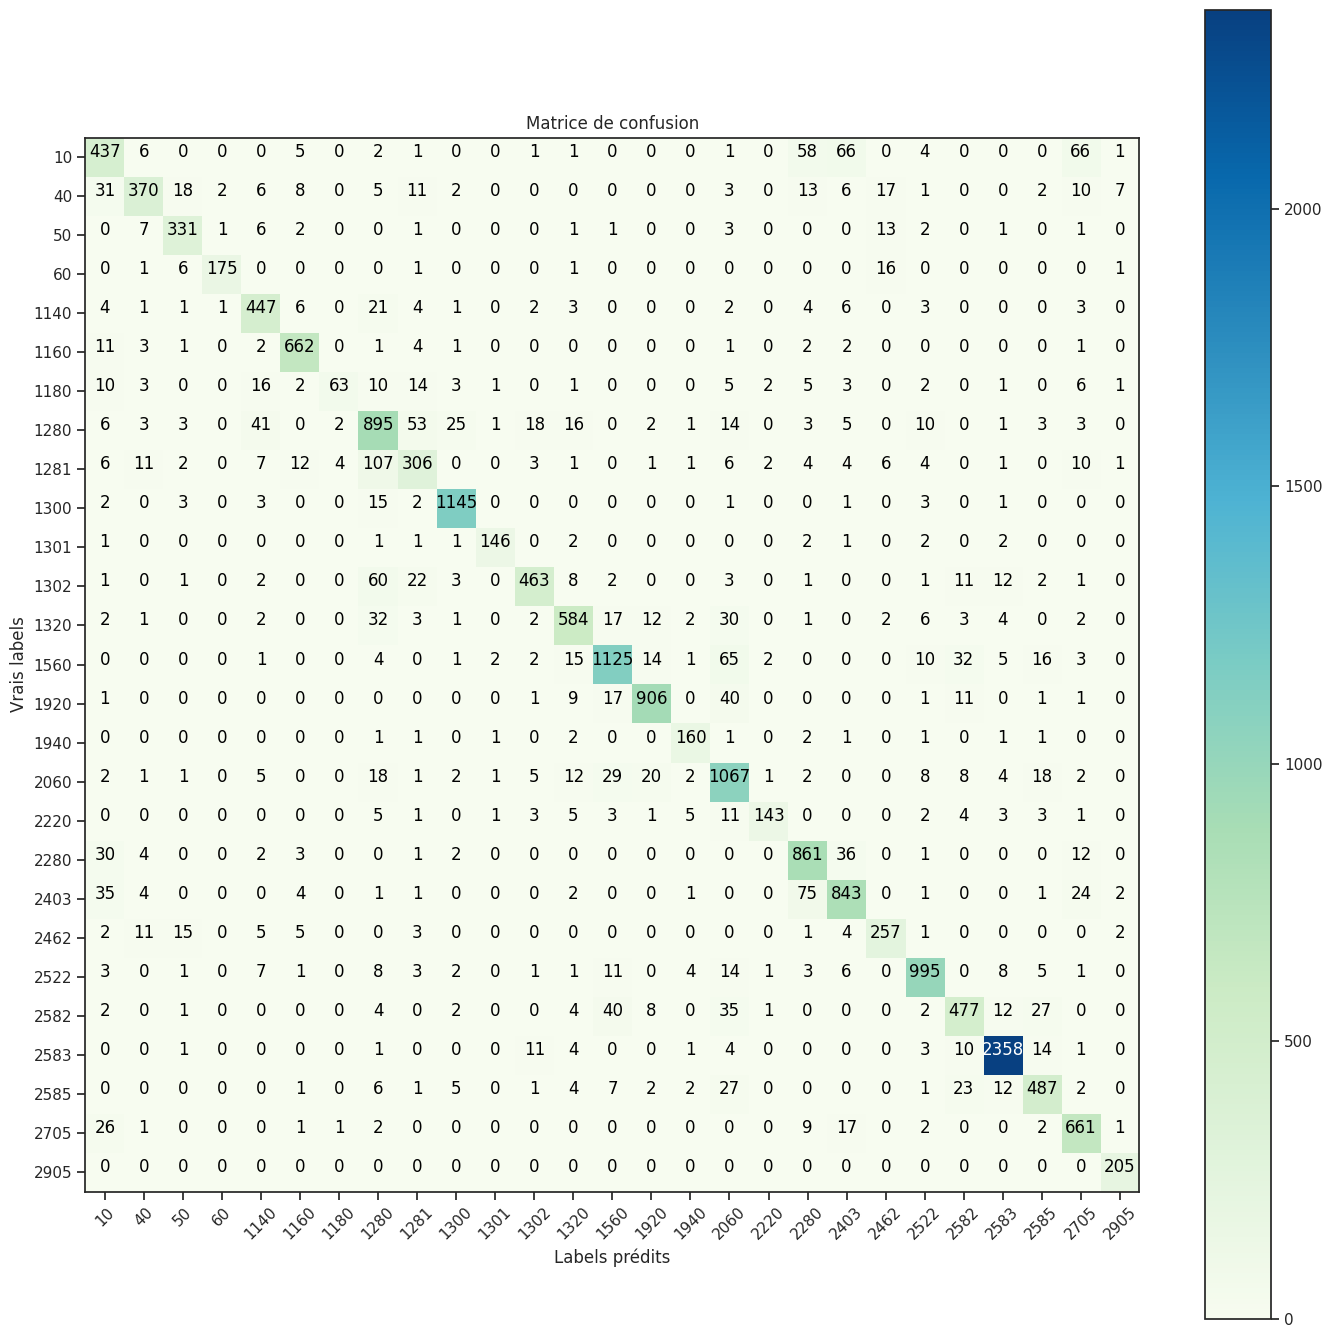

In [219]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

cnf_matrix = confusion_matrix(y_true, y_pred)

classes = sorted(list(df.prdtypecode.unique()))

plt.figure(figsize=(17,17))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='GnBu')

plt.title("Matrice de confusion")

plt.colorbar()

tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation = 45)

plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):

    plt.text(j, i, cnf_matrix[i, j], horizontalalignment="center",

             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')

plt.xlabel('Labels prédits')

plt.show()


In [220]:
df.groupby('prdtypecode')['prdtypecode'].count()

prdtypecode
10       649
40       512
50       370
60       201
1140     509
1160     691
1180     148
1280    1105
1281     499
1300    1176
1301     159
1302     593
1320     706
1560    1298
1920     988
1940     172
2060    1209
2220     191
2280     952
2403     994
2462     306
2522    1075
2582     615
2583    2408
2585     581
2705     723
2905     205
Name: prdtypecode, dtype: int64